In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (12,9)

## Read the data

In [3]:
wine_data = load_wine()

wine_df = pd.DataFrame(
    data=wine_data.data,
    columns=wine_data.feature_names
)

wine_df['target'] = wine_data.target

wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


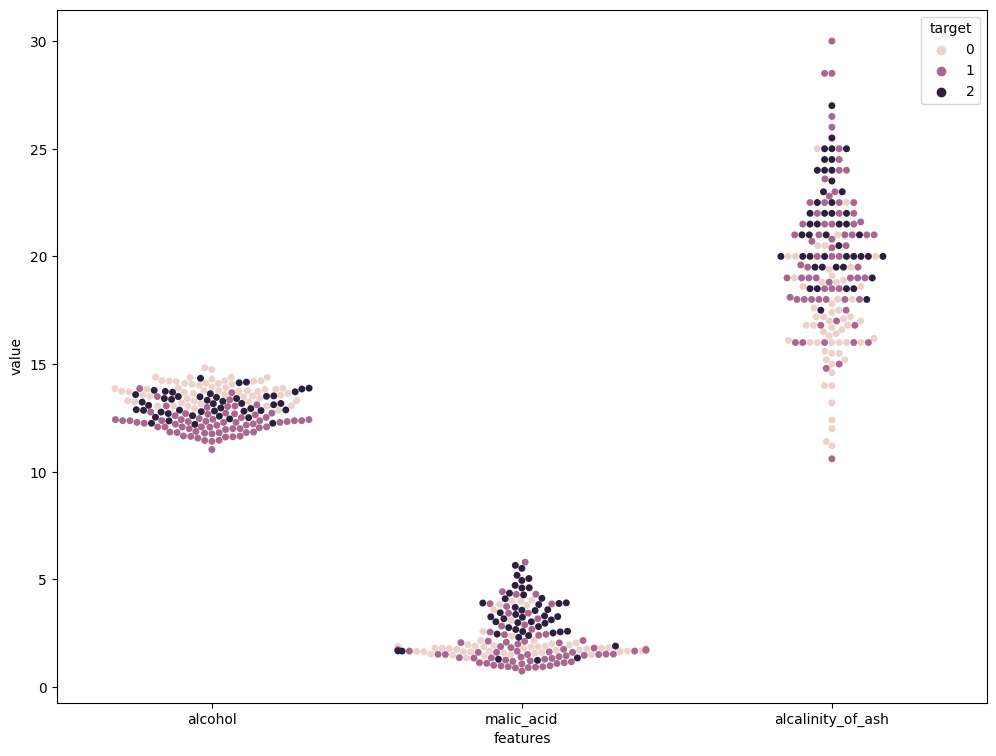

In [4]:
from seaborn import swarmplot

data_to_plot = pd.melt(wine_df[['alcohol', 'malic_acid', 'alcalinity_of_ash', 'target']],
                       id_vars='target',
                       var_name='features',
                       value_name='value')

swarmplot(data=data_to_plot, x='features', y='value', hue='target');

### Features Count

In [5]:
wine_df['target'].value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

### Features Bar Chart

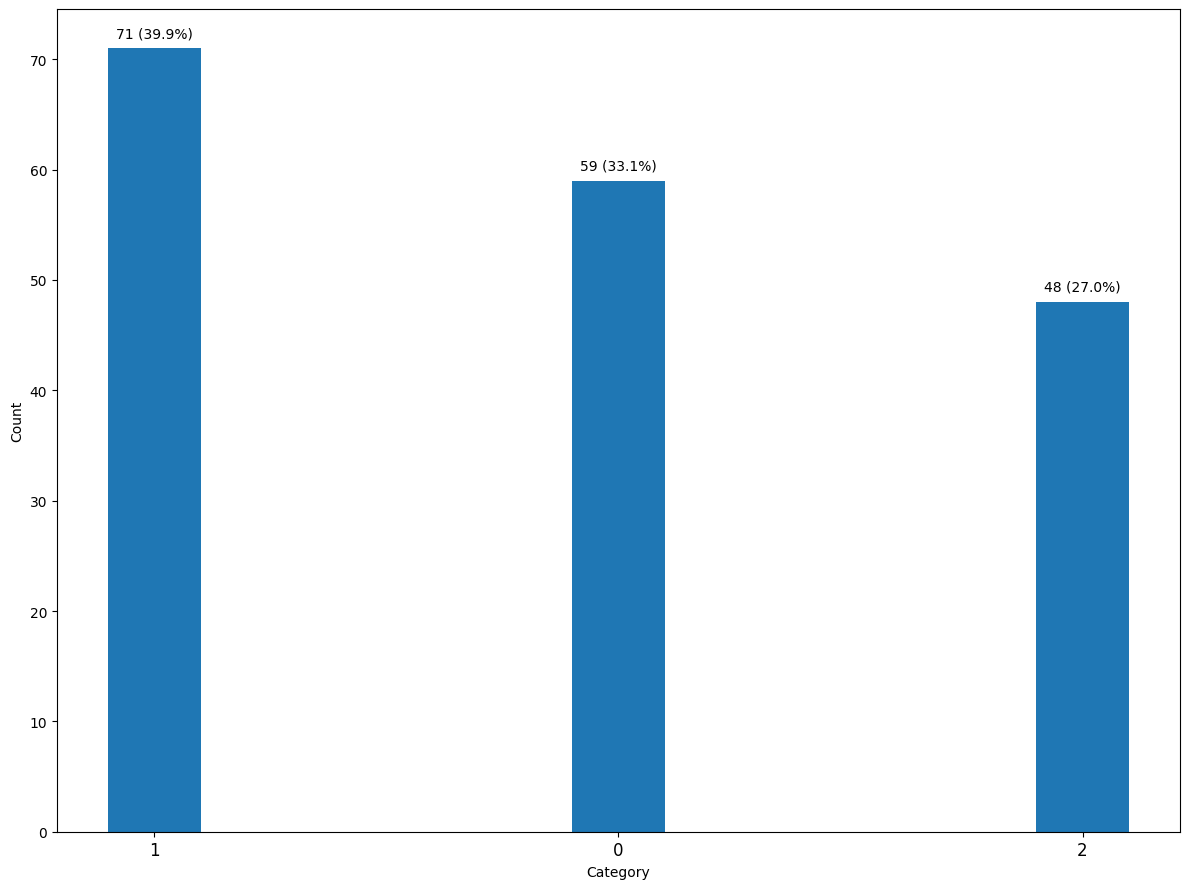

In [6]:
import matplotlib.pyplot as plt

# Assuming 'target' is the column of interest
value_counts = wine_df['target'].value_counts()
categories = value_counts.index
counts = value_counts.values

total = sum(counts)
percentage = [val / total * 100 for val in counts]

fig, ax = plt.subplots(figsize=(12, 9))

x = range(len(categories))

ax.bar(x, counts, width=0.2)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)

for index, value in enumerate(counts):
    plt.text(x=int(index), y=value + 1, s=f'{value} ({percentage[index]:.1f}%)', ha='center')

plt.tight_layout()
plt.show()

### Train/test split

In [7]:
from sklearn.model_selection import train_test_split

# Assuming the last column is the target column
X = wine_df.iloc[:, :-1]
y = wine_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

In [8]:
print(X_train.shape)
print(X_test.shape)

(124, 13)
(54, 13)


<hr>

## Baseline model: Gradient Boosting Classifier with all features

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Initialize classifier
gbc = GradientBoostingClassifier(max_depth=5, random_state=42)

# Train classifier using all features
gbc.fit(X_train, y_train)

# Make predictions
preds = gbc.predict(X_test)

# Evaluate the model using the F1-score
f1_score_all = round(f1_score(y_test, preds, average='weighted'), 3)

print(f1_score_all)

0.908


# Feature selection techniques

# Variance threshold

In [10]:
X_train_v1, X_test_v1, y_tain_v1, y_test_v1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

## Calculate the variance of each feature

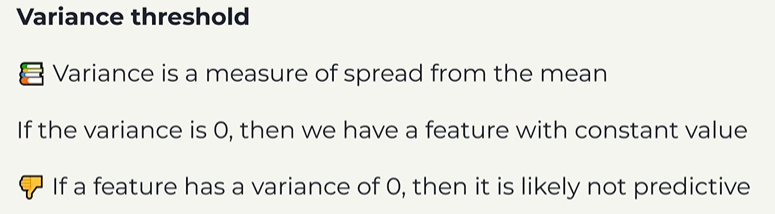

In [11]:
from IPython.display import Image, display

# Replace 'path/to/image.jpg' with the actual path or URL of your image
image_path = 'variance.png'

# Specify width and height
width = 500
height = 300

# Display the image
display(Image(filename=image_path, width=width, height=height))

In [12]:
X_train_v1.var(axis=0)

alcohol                             0.658341
malic_acid                          1.123507
ash                                 0.072433
alcalinity_of_ash                  11.471279
magnesium                         232.071532
total_phenols                       0.393226
flavanoids                          0.912299
nonflavanoid_phenols                0.013873
proanthocyanins                     0.335108
color_intensity                     5.669722
hue                                 0.052891
od280/od315_of_diluted_wines        0.470021
proline                         94906.710923
dtype: float64

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

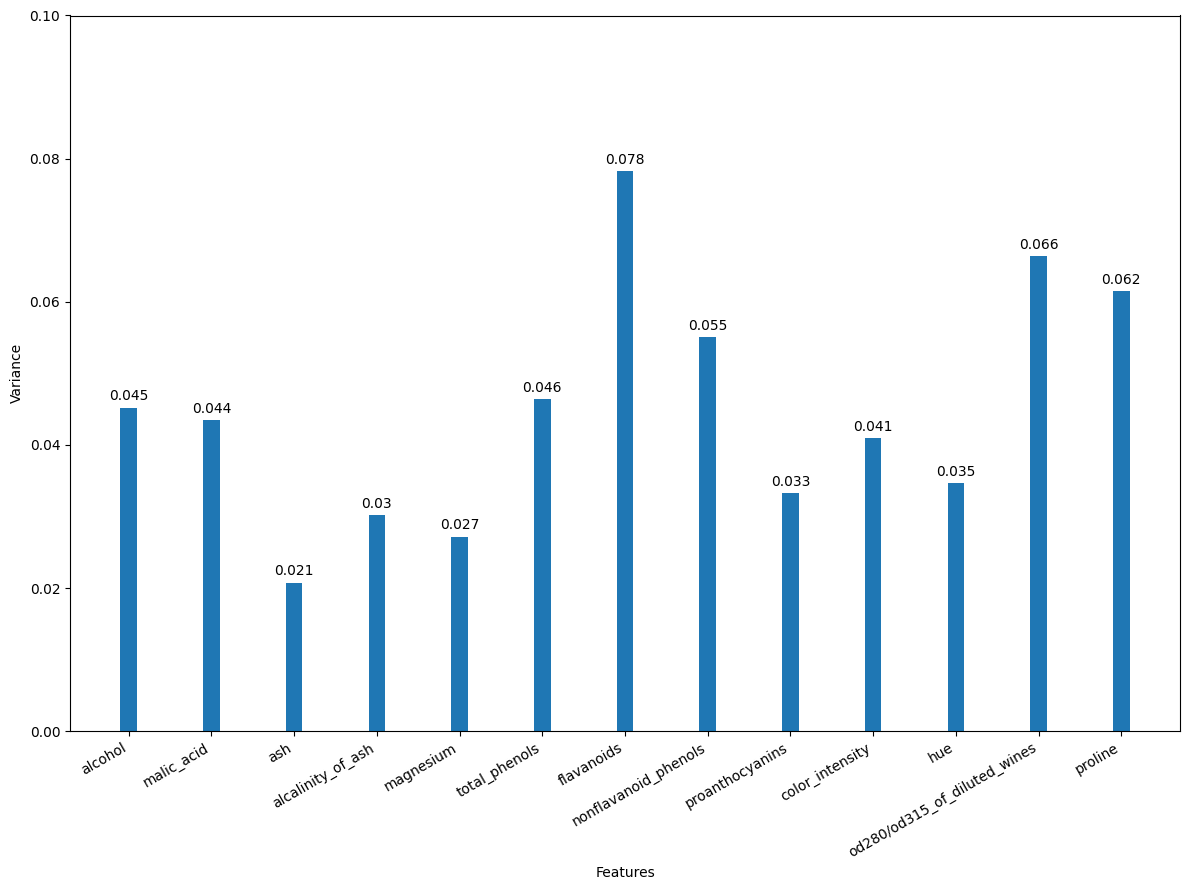

In [14]:
fig, ax = plt.subplots()

x = X.columns
y = scaled_X_train_v1.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')
    
fig.autofmt_xdate()
plt.tight_layout()

### Using a threshold of 0.03 - 'ash' and 'magnesium' will be removed

In [15]:
sel_X_train_v1 = X_train_v1.drop(['ash', 'magnesium'], axis=1)
sel_X_test_v1 = X_test_v1.drop(['ash', 'magnesium'], axis=1)

gbc.fit(sel_X_train_v1, y_train)

var_preds = gbc.predict(sel_X_test_v1)

f1_score_var = round(f1_score(y_test_v1, var_preds, average='weighted'), 3)

print(f1_score_var)

0.963


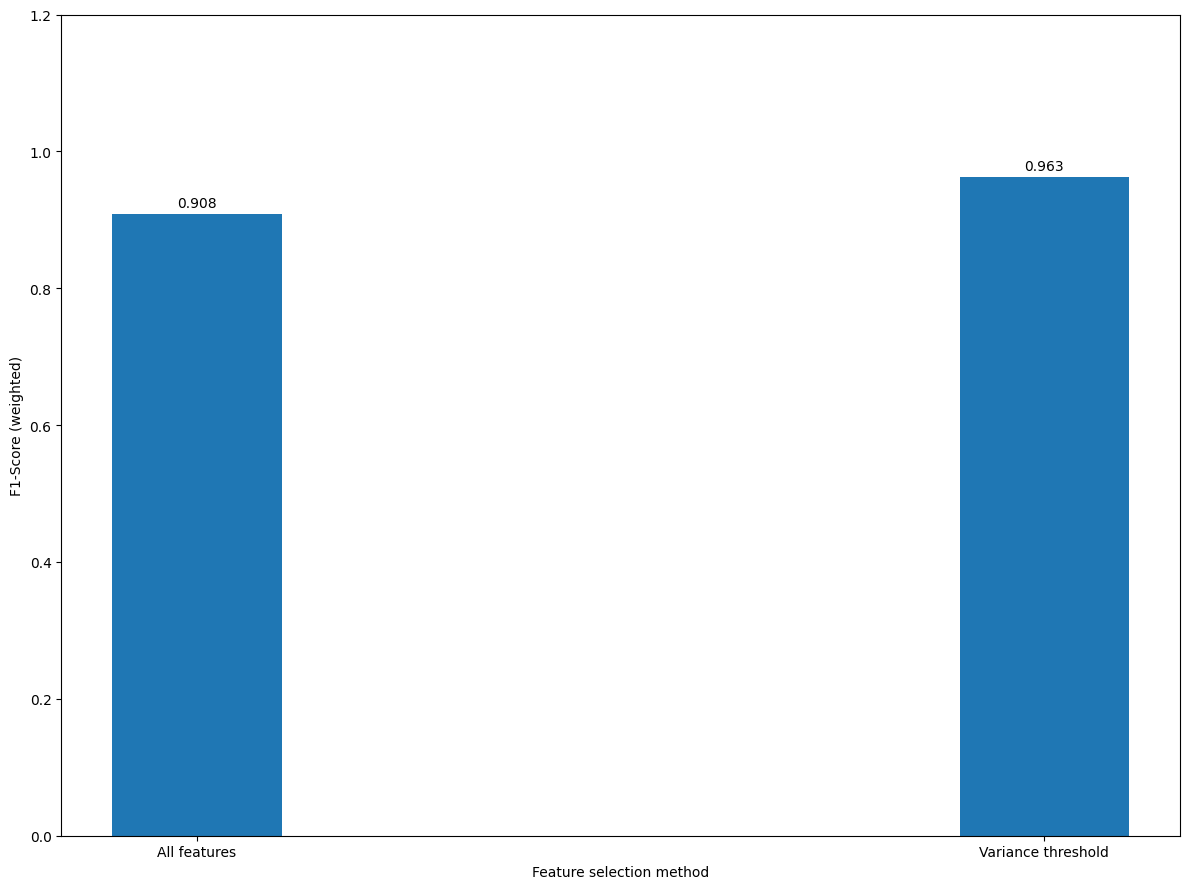

In [16]:
fig, ax = plt.subplots()

x = ['All features', 'Variance threshold']
y = [f1_score_all, f1_score_var]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.01, s=str(round(value,3)), ha='center')
    
plt.tight_layout()

# K-best features

In [17]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

## Import KBest

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

f1_score_list = []

for k in range(1, 14):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_v2, y_train_v2)
    
    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)
    
    gbc.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = gbc.predict(sel_X_test_v2)
    
    f1_score_kbest = round(f1_score(y_test_v2, kbest_preds, average='weighted'), 3)
    
    f1_score_list.append(f1_score_kbest)

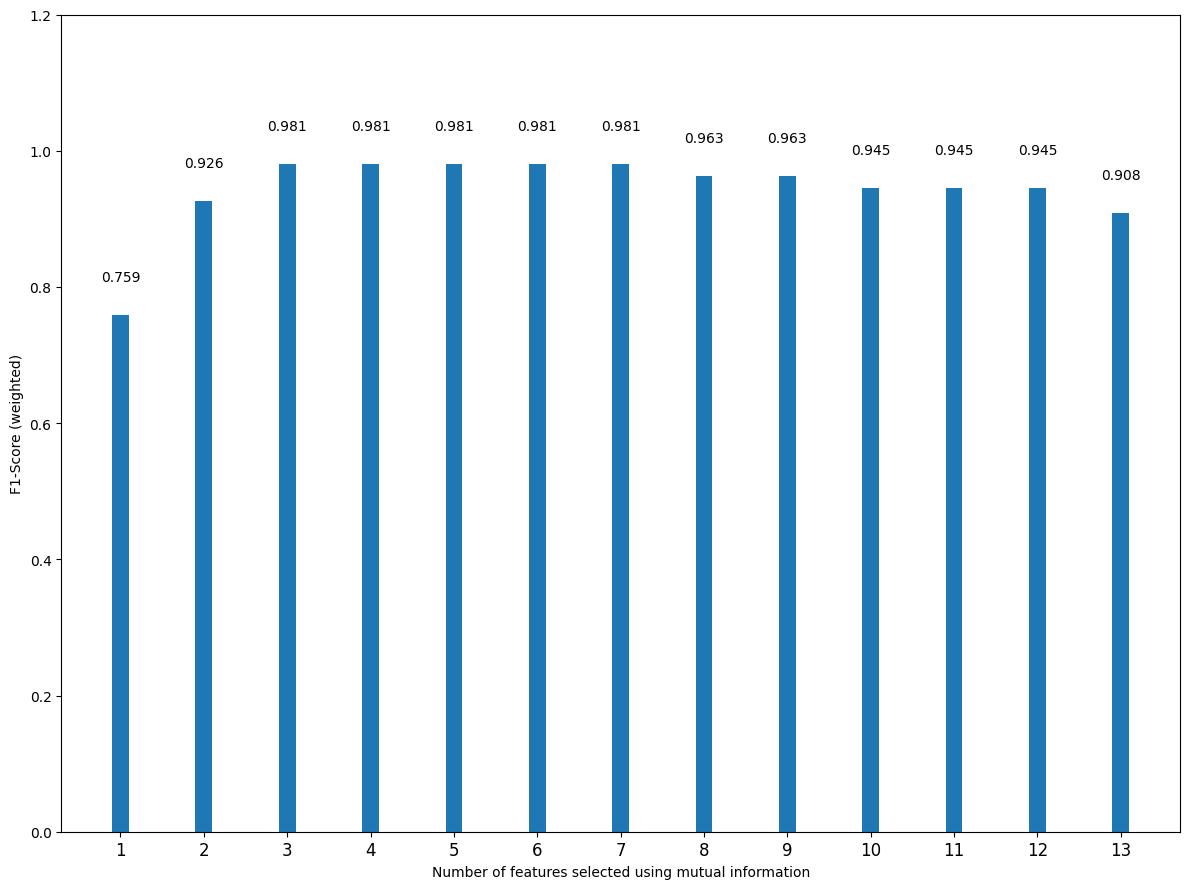

In [19]:
fig, ax = plt.subplots()

x = np.arange(1, 14)
y = f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using mutual information')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 14))
ax.set_xticklabels(np.arange(1, 14), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')
    
plt.tight_layout()

In [20]:
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## Features being selected

In [21]:
selector = SelectKBest(mutual_info_classif, k=3)
selector.fit(X_train_v2, y_train_v2)

selected_feature_mask = selector.get_support()

selected_features = X_train_v2.columns[selected_feature_mask]

selected_features

Index(['flavanoids', 'color_intensity', 'proline'], dtype='object')

<hr>

![Alt text](K-best.png)

![Alt text](K.png)

<hr>

# Recursive feature elimination (RFE)

![Alt text](rfe.png)

![Alt text](rfe2.png)

In [22]:
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

## Import RFE

In [23]:
from sklearn.feature_selection import RFE

rfe_f1_score_list = []

for k in range(1, 14):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_v3, y_train_v3)
    
    sel_X_train_v3 = RFE_selector.transform(X_train_v3)
    sel_X_test_v3 = RFE_selector.transform(X_test_v3)
    
    gbc.fit(sel_X_train_v3, y_train_v3)
    RFE_preds = gbc.predict(sel_X_test_v3)
    
    f1_score_rfe = round(f1_score(y_test_v3, RFE_preds, average='weighted'), 3)
    
    rfe_f1_score_list.append(f1_score_rfe)

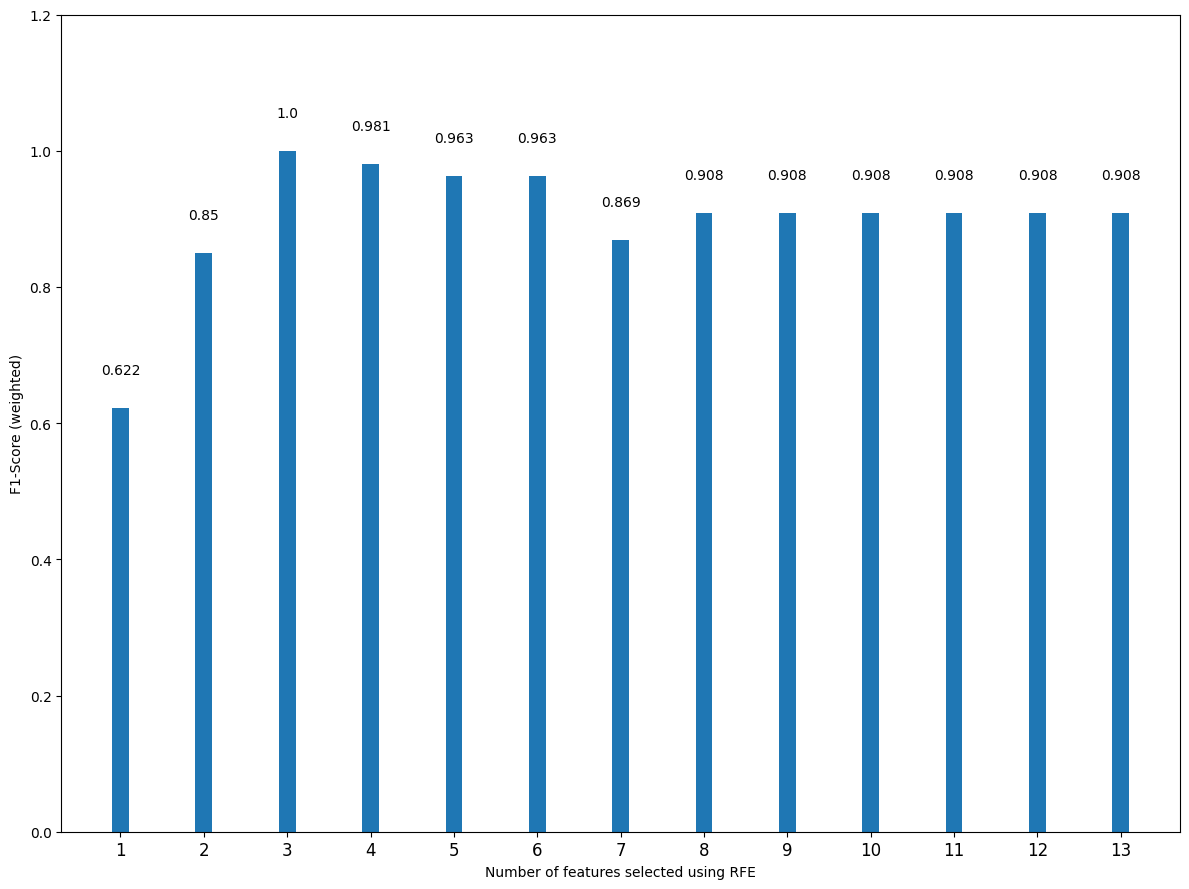

In [25]:
fig, ax = plt.subplots()

x = np.arange(1, 14)
y = rfe_f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using RFE')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 14))
ax.set_xticklabels(np.arange(1, 14), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')
    
plt.tight_layout()

## Features being selected

In [26]:
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [27]:
RFE_selector = RFE(estimator=gbc, n_features_to_select=3, step=10)
RFE_selector.fit(X_train_v3, y_train_v3)

selected_features_mask = RFE_selector.get_support()

selected_features = X_train_v3.columns[selected_features_mask]
selected_features

Index(['color_intensity', 'od280/od315_of_diluted_wines', 'proline'], dtype='object')

<hr>

# Boruta

![Alt text](boruta.png)
![Alt text](boruta2.png)

![Alt text](boruta3.png)

In [31]:
X_train_v4, X_test_v4, y_train_v4, y_test_v4 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

## Import Boruta

In [44]:
!pip install Boruta

In [52]:
from boruta import BorutaPy

boruta_selector = BorutaPy(gbc, random_state=42)

boruta_selector.fit(X_train_v4.values, y_train_v4.values.ravel())

sel_X_train_v4 = boruta_selector.transform(X_train_v4.values)
sel_X_test_v4 = boruta_selector.transform(X_test_v4.values)

gbc.fit(sel_X_train_v4, y_train_v4)

boruta_preds = gbc.predict(sel_X_test_v4)

boruta_f1_score = round(f1_score(y_test_v4, boruta_preds, average='weighted'), 3)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

# Load the Wine dataset
wine = load_wine()
X = wine.data
y = wine.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a gradient boosting classifier
gbc = GradientBoostingClassifier(random_state=42)

# Use SelectFromModel for feature selection
sfm = SelectFromModel(gbc, threshold='median')
sfm.fit(X_train, y_train)

# Transform the training and testing sets to keep only the selected features
sel_X_train = sfm.transform(X_train)
sel_X_test = sfm.transform(X_test)

# Train the classifier on the selected features
gbc.fit(sel_X_train, y_train)

# Make predictions on the testing set
sfm_preds = gbc.predict(sel_X_test)

# Evaluate the F1 score of the model
sfm_f1_score = round(f1_score(y_test, sfm_preds, average='weighted'), 3)
print(f"SelectFromModel F1 Score: {sfm_f1_score}")


SelectFromModel F1 Score: 0.944


<hr>

NameError: name 'boruta_f1_score' is not defined

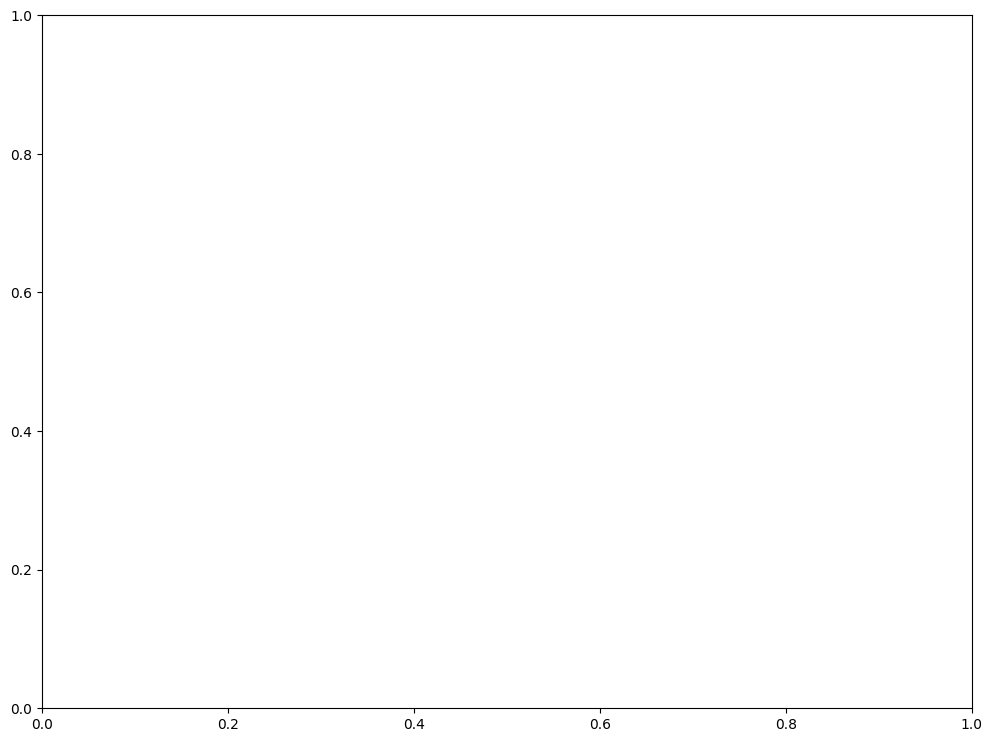

In [51]:
fig, ax = plt.subplots()

x = ['All features (13)', 'Variance threshold (11)', 'Filter - MI (3)', 'RFE (3)', 'Boruta (9)']
y = [f1_score_all, f1_score_var, 0.981, 1.0, boruta_f1_score]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)

for i, v in enumerate(y):
    plt.text(x=i, y=v+0.01, s=str(v), ha='center')
    
plt.tight_layout()